In [1]:
import pandas as pd

TICKER = "ETHUSDC"
STOP_DATE = pd.Timestamp(year=2025, month=1, day=1, hour=12)
LONGEST_PERIOD_MONTHS = 12
NUM_FOLDS = 4 # note: this will test NUM_FOLDS-1 times
MIN_LOOKBACK = 5
MAX_LOOKBACK = 20
NUM_FEATURES = 10

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

SAVE_CSV = TICKER + "_results.csv"
SAVE_MODEL = TICKER + "_model.h5"

# optuna hyperparams
def HYPERPARAMS(funct, **kwargs):
    def objective(trial):
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
        batch_size = trial.suggest_int("batch_size", 16, 128)
        epochs = trial.suggest_int("epochs", 10, 50)
        activation = trial.suggest_categorical("activation", ["relu", "tanh"])
        lstm_units = trial.suggest_int("lstm_units", 32, 128)
        lookback = trial.suggest_int("lookback", MIN_LOOKBACK, MAX_LOOKBACK)
        
        hyperparams = {
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'epochs': epochs,
            'lstm_units': lstm_units,
            'activation': activation,
            'lookback': lookback,
        }
        return funct(hyperparams=hyperparams, **kwargs)
    return objective


def appendResult(hyperparams=None, scores=None):
    if not scores:
        open(SAVE_CSV, "w").close()
        return
    with open(SAVE_CSV, "a") as f:
        if f.tell() == 0:
            f.write(",".join([*hyperparams.keys(), *scores.keys()]) + "\n")
        f.write(",".join(str(i) for i in [*hyperparams.values(), *scores.values()]) + "\n")

c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def dummy_npwarn_decorator_factory():
  def npwarn_decorator(x):
    return x
  return npwarn_decorator
np._no_nep50_warning = getattr(np, '_no_nep50_warning', dummy_npwarn_decorator_factory)


# Okay, but seriously there's a big problem

The LSTM is trained on min-max scaled data from 2024-2025.

But when we do the RL, the min-max scaling happens from 2025-present.

So the min-max scaling isn't even the same.

In [4]:
def a(x):
    a.b = 5
    def updateB():
        a.b = 10

    updateB()

    return x + a.b
a(5)

15

In [5]:
"""
=== Q&A ===

RL Model
[      Train      ] [  Test  ]
[  Train  ]  [Test]
LSTM Model


Q: Will this program only have access to "train" data? Should it have access to "test" data?
A: It should not have access to "test" data. If we want to see how it performs on test data,
we run a separate experiment from "training". Even automated performance monitoring on the
"test" data will be conducted globally, not locally.

Q: How will this program optimize the LSTM model before handing it off?
Step 1: generate Walk-Forward Test Folds (A test B, AB test C, ABC test D, ... A-Y test Z)
Step 2: use optuna to find the hyperparameters that have the best average MSE
Step 3: train those hyperparameters on A-Z, publish

Q: What financial indicators? What target?
A: No financial indicators
   Predicts "Open"

"""


from sklearn import preprocessing
def getAssetData(ticker, maxPeriodLength_months=12):
    df = pd.read_csv(f'assets/{ticker}.csv')

    # filter to longest contiguous before STOP_DATE
    df.drop(columns=["Ignore", "Close time"], inplace=True)
    df["Open time"] = df["Open time"].apply(lambda x: x * 1000 if len(str(x)) < len("1738369800000000") else x)
    df["Open time"] = pd.to_datetime(df["Open time"], unit='us')
    df.set_index("Open time", inplace=True)
    df.sort_index(inplace=True)

    df = df[df.index < STOP_DATE]

    df["Gap"] = df.index.to_series().diff().dt.total_seconds().div(60).fillna(0)
    valid_intervals = df[df["Gap"] <= 30]
    last_gap_index = df[df["Gap"] > 30].index[-1]
    df = df.loc[last_gap_index:]
    

    df.drop(columns=["Gap"], inplace=True)

    # add financial indicators

    # chop off N/A or longer than maxPeriodLength
    df.dropna(inplace=True)
    df = df[df.index > (df.index[-1] - pd.DateOffset(months=maxPeriodLength_months))]

    # normalize except the target
    target = df["Open"].copy().pct_change()
    display(target)
    target.fillna(0, inplace=True)
    scaler = preprocessing.MinMaxScaler()
    normalized_columns = scaler.fit_transform(df)
    df = pd.DataFrame(normalized_columns, columns=df.columns, index=df.index)
    df["Target"] = target
    display(df["Target"])

    return df

def formatLSTMInput(df, numFolds=4, lookback=5):
    foldEndIndices = [int(len(df) * (i + 1) / numFolds) for i in range(numFolds)]
    foldEndIndices = [0] + foldEndIndices + [len(df)]

    folds = [df.iloc[foldEndIndices[i]:foldEndIndices[i + 1]] for i in range(len(foldEndIndices) - 1)]
    folds = [fold.reset_index(drop=True) for fold in folds]

    def formatXy(fold):
        if len(fold) <= lookback:
            print("Your fold is smaller than the lookback+1 period, so bro, fix it, please")
            return None, None
        X = pd.concat([fold.shift(i) for i in range(lookback, 0, -1)], axis=1).dropna()
        X = np.reshape(X.values, (len(X), lookback, len(fold.columns)))
        y = np.reshape(fold["Target"].shift(-lookback).dropna(), (-1, 1))
        return X, y

    # format X and format Y
    trainTestFolds = []
    for i in range(len(folds)-2):
        train_fold = pd.concat(folds[0:i + 1], axis=0)
        test_fold = folds[i + 1]
        X_train, y_train = formatXy(train_fold)
        X_test, y_test = formatXy(test_fold)
        trainTestFolds.append({
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test
        })
    
    train_final = pd.concat(folds, axis=0)
    X_final, y_final = formatXy(train_final)
    finalData = {
        'X_train': X_final,
        'y_train': y_final,
        'open': train_final["Open"].values[lookback:],
    }

    return { 'train-test-folds': trainTestFolds, 'final-train': finalData }

def generateModel(hyperparams):
    # build the Keras sequential model
    learning_rate = hyperparams.get('learning_rate', 0.001)
    batch_size = hyperparams.get('batch_size', 32)
    epochs = hyperparams.get('epochs', 20)
    lstm_units = hyperparams.get('lstm_units', 50)
    activation = hyperparams.get('activation', 'relu')
    lookback = hyperparams.get('lookback', 5)
    input_shape = hyperparams.get('input_shape', (lookback, NUM_FEATURES))

    model = Sequential([
        LSTM(lstm_units, activation='relu', input_shape=input_shape),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def KFoldsTrainTest(hyperparams, data):
    inputs = formatLSTMInput(data, numFolds=NUM_FOLDS, lookback=hyperparams['lookback'])
    trainTestFolds = inputs['train-test-folds']

    hyperparams = hyperparams.copy()
    hyperparams['input_shape'] = trainTestFolds[0]['X_train'].shape[1:]

    print(f"Hyperparameters: {hyperparams}")
    print("Shape: ", trainTestFolds[0]['X_train'].shape)

    # train the model on each fold and evaluate
    mse_scores = []
    for fold in trainTestFolds:
        model = generateModel(hyperparams)
        X_train, y_train = fold['X_train'], fold['y_train']
        X_test, y_test = fold['X_test'], fold['y_test']

        # fit the model
        model.fit(X_train, y_train, epochs=hyperparams['epochs'], batch_size=hyperparams['batch_size'], verbose=0)

        # evaluate the model
        mse = model.evaluate(X_test, y_test, verbose=0)
        mse_scores.append(mse)

    # return the average MSE
    appendResult(hyperparams, { 'mse_scores': ";".join(str(i) for i in mse_scores) })
    return np.mean(mse_scores)

def getOptimalModel(saveAs):
    appendResult()

    data = getAssetData(TICKER, LONGEST_PERIOD_MONTHS)
    

    objective = HYPERPARAMS(KFoldsTrainTest, data=data)
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=25)
    bestHyperparams = study.best_trial.params

    finalData = formatLSTMInput(data, NUM_FOLDS, bestHyperparams['lookback'])['final-train']

    model = generateModel(bestHyperparams)
    model.fit(finalData['X_train'], finalData['y_train'], epochs=bestHyperparams['epochs'], batch_size=bestHyperparams['batch_size'], verbose=1)
    model.save(saveAs)
    print(f"Best hyperparameters: {bestHyperparams}")


    # Predict on the training data
    predictions = model.predict(finalData['X_train'])

    print(finalData['open'])

    # Calculate errors
    errors = (predictions.flatten()) - finalData['y_train'].flatten()

    # Plot error bars
    plt.figure(figsize=(10, 6))
    plt.errorbar(range(len(errors)), predictions.flatten(), yerr=abs(errors), ecolor='red', label='Prediction with Error Bars')
    plt.xlabel('Sample Index')
    plt.ylabel('Predicted Value')
    plt.title('Prediction Error Bars')
    plt.legend()
    plt.show()

    return { 'model': model, 'hyperparams': bestHyperparams }

Open time
2024-01-01 12:00:00         NaN
2024-01-01 12:30:00   -0.000564
2024-01-01 13:00:00   -0.001910
2024-01-01 13:30:00    0.002988
2024-01-01 14:00:00   -0.000707
                         ...   
2025-01-01 09:30:00   -0.004197
2025-01-01 10:00:00    0.003425
2025-01-01 10:30:00   -0.000427
2025-01-01 11:00:00   -0.001921
2025-01-01 11:30:00    0.002560
Name: Open, Length: 17568, dtype: float64

Open time
2024-01-01 12:00:00    0.000000
2024-01-01 12:30:00   -0.000564
2024-01-01 13:00:00   -0.001910
2024-01-01 13:30:00    0.002988
2024-01-01 14:00:00   -0.000707
                         ...   
2025-01-01 09:30:00   -0.004197
2025-01-01 10:00:00    0.003425
2025-01-01 10:30:00   -0.000427
2025-01-01 11:00:00   -0.001921
2025-01-01 11:30:00    0.002560
Name: Target, Length: 17568, dtype: float64

[I 2025-03-29 14:59:01,979] A new study created in memory with name: no-name-7abbcaef-048a-4855-a292-458a32fdaba0
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.0004010774779928836, 'batch_size': 55, 'epochs': 42, 'lstm_units': 103, 'activation': 'relu', 'lookback': 18, 'input_shape': (18, 10)}
Shape:  (4374, 18, 10)


[I 2025-03-29 15:00:30,736] Trial 0 finished with value: 1.6112015259750478e-06 and parameters: {'learning_rate': 0.0004010774779928836, 'batch_size': 55, 'epochs': 42, 'activation': 'relu', 'lstm_units': 103, 'lookback': 18}. Best is trial 0 with value: 1.6112015259750478e-06.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.000618424331041106, 'batch_size': 22, 'epochs': 47, 'lstm_units': 64, 'activation': 'relu', 'lookback': 9, 'input_shape': (9, 10)}
Shape:  (4383, 9, 10)


[I 2025-03-29 15:02:01,985] Trial 1 finished with value: 2.638559370401102e-06 and parameters: {'learning_rate': 0.000618424331041106, 'batch_size': 22, 'epochs': 47, 'activation': 'relu', 'lstm_units': 64, 'lookback': 9}. Best is trial 0 with value: 1.6112015259750478e-06.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 4.0534857970037343e-05, 'batch_size': 115, 'epochs': 47, 'lstm_units': 60, 'activation': 'relu', 'lookback': 17, 'input_shape': (17, 10)}
Shape:  (4375, 17, 10)


[I 2025-03-29 15:02:49,968] Trial 2 finished with value: 1.1372226860354809e-05 and parameters: {'learning_rate': 4.0534857970037343e-05, 'batch_size': 115, 'epochs': 47, 'activation': 'relu', 'lstm_units': 60, 'lookback': 17}. Best is trial 0 with value: 1.6112015259750478e-06.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.00031617071806176614, 'batch_size': 23, 'epochs': 22, 'lstm_units': 47, 'activation': 'relu', 'lookback': 18, 'input_shape': (18, 10)}
Shape:  (4374, 18, 10)


[I 2025-03-29 15:03:48,037] Trial 3 finished with value: 5.70387703646702e-06 and parameters: {'learning_rate': 0.00031617071806176614, 'batch_size': 23, 'epochs': 22, 'activation': 'relu', 'lstm_units': 47, 'lookback': 18}. Best is trial 0 with value: 1.6112015259750478e-06.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.000430855057955439, 'batch_size': 72, 'epochs': 30, 'lstm_units': 79, 'activation': 'tanh', 'lookback': 16, 'input_shape': (16, 10)}
Shape:  (4376, 16, 10)


[I 2025-03-29 15:04:32,018] Trial 4 finished with value: 1.0379343090486751e-05 and parameters: {'learning_rate': 0.000430855057955439, 'batch_size': 72, 'epochs': 30, 'activation': 'tanh', 'lstm_units': 79, 'lookback': 16}. Best is trial 0 with value: 1.6112015259750478e-06.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.0030832933825798285, 'batch_size': 85, 'epochs': 18, 'lstm_units': 123, 'activation': 'tanh', 'lookback': 12, 'input_shape': (12, 10)}
Shape:  (4380, 12, 10)


[I 2025-03-29 15:05:01,237] Trial 5 finished with value: 2.1526019130154356e-05 and parameters: {'learning_rate': 0.0030832933825798285, 'batch_size': 85, 'epochs': 18, 'activation': 'tanh', 'lstm_units': 123, 'lookback': 12}. Best is trial 0 with value: 1.6112015259750478e-06.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 1.055451030116085e-05, 'batch_size': 52, 'epochs': 41, 'lstm_units': 49, 'activation': 'tanh', 'lookback': 20, 'input_shape': (20, 10)}
Shape:  (4372, 20, 10)


[I 2025-03-29 15:06:01,450] Trial 6 finished with value: 6.258821334389116e-06 and parameters: {'learning_rate': 1.055451030116085e-05, 'batch_size': 52, 'epochs': 41, 'activation': 'tanh', 'lstm_units': 49, 'lookback': 20}. Best is trial 0 with value: 1.6112015259750478e-06.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.002182182946817078, 'batch_size': 126, 'epochs': 39, 'lstm_units': 56, 'activation': 'relu', 'lookback': 10, 'input_shape': (10, 10)}
Shape:  (4382, 10, 10)


[I 2025-03-29 15:06:28,473] Trial 7 finished with value: 1.2190992492833175e-05 and parameters: {'learning_rate': 0.002182182946817078, 'batch_size': 126, 'epochs': 39, 'activation': 'relu', 'lstm_units': 56, 'lookback': 10}. Best is trial 0 with value: 1.6112015259750478e-06.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 3.080922281129671e-05, 'batch_size': 100, 'epochs': 49, 'lstm_units': 41, 'activation': 'relu', 'lookback': 11, 'input_shape': (11, 10)}
Shape:  (4381, 11, 10)


[I 2025-03-29 15:07:02,236] Trial 8 finished with value: 4.572187587352043e-06 and parameters: {'learning_rate': 3.080922281129671e-05, 'batch_size': 100, 'epochs': 49, 'activation': 'relu', 'lstm_units': 41, 'lookback': 11}. Best is trial 0 with value: 1.6112015259750478e-06.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 3.466984182285568e-05, 'batch_size': 90, 'epochs': 32, 'lstm_units': 109, 'activation': 'relu', 'lookback': 6, 'input_shape': (6, 10)}
Shape:  (4386, 6, 10)


[I 2025-03-29 15:07:29,856] Trial 9 finished with value: 9.198420457323664e-06 and parameters: {'learning_rate': 3.466984182285568e-05, 'batch_size': 90, 'epochs': 32, 'activation': 'relu', 'lstm_units': 109, 'lookback': 6}. Best is trial 0 with value: 1.6112015259750478e-06.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.008402567245871857, 'batch_size': 49, 'epochs': 10, 'lstm_units': 100, 'activation': 'tanh', 'lookback': 15, 'input_shape': (15, 10)}
Shape:  (4377, 15, 10)


[I 2025-03-29 15:07:52,464] Trial 10 finished with value: 1.9345640036287175e-05 and parameters: {'learning_rate': 0.008402567245871857, 'batch_size': 49, 'epochs': 10, 'activation': 'tanh', 'lstm_units': 100, 'lookback': 15}. Best is trial 0 with value: 1.6112015259750478e-06.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.0003206044832303934, 'batch_size': 24, 'epochs': 42, 'lstm_units': 81, 'activation': 'relu', 'lookback': 7, 'input_shape': (7, 10)}
Shape:  (4385, 7, 10)


[I 2025-03-29 15:09:09,312] Trial 11 finished with value: 7.833255513863454e-07 and parameters: {'learning_rate': 0.0003206044832303934, 'batch_size': 24, 'epochs': 42, 'activation': 'relu', 'lstm_units': 81, 'lookback': 7}. Best is trial 11 with value: 7.833255513863454e-07.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.0002205418754384301, 'batch_size': 40, 'epochs': 37, 'lstm_units': 87, 'activation': 'relu', 'lookback': 5, 'input_shape': (5, 10)}
Shape:  (4387, 5, 10)


[I 2025-03-29 15:09:50,194] Trial 12 finished with value: 3.339486625009158e-06 and parameters: {'learning_rate': 0.0002205418754384301, 'batch_size': 40, 'epochs': 37, 'activation': 'relu', 'lstm_units': 87, 'lookback': 5}. Best is trial 11 with value: 7.833255513863454e-07.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.000173094314337107, 'batch_size': 62, 'epochs': 42, 'lstm_units': 82, 'activation': 'relu', 'lookback': 8, 'input_shape': (8, 10)}
Shape:  (4384, 8, 10)


[I 2025-03-29 15:10:32,919] Trial 13 finished with value: 4.098986740549056e-06 and parameters: {'learning_rate': 0.000173094314337107, 'batch_size': 62, 'epochs': 42, 'activation': 'relu', 'lstm_units': 82, 'lookback': 8}. Best is trial 11 with value: 7.833255513863454e-07.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.0009846188414176376, 'batch_size': 30, 'epochs': 32, 'lstm_units': 100, 'activation': 'relu', 'lookback': 14, 'input_shape': (14, 10)}
Shape:  (4378, 14, 10)


[I 2025-03-29 15:11:50,216] Trial 14 finished with value: 2.360640905862965e-06 and parameters: {'learning_rate': 0.0009846188414176376, 'batch_size': 30, 'epochs': 32, 'activation': 'relu', 'lstm_units': 100, 'lookback': 14}. Best is trial 11 with value: 7.833255513863454e-07.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 8.502425870981268e-05, 'batch_size': 16, 'epochs': 36, 'lstm_units': 128, 'activation': 'relu', 'lookback': 20, 'input_shape': (20, 10)}
Shape:  (4372, 20, 10)


[I 2025-03-29 15:16:08,949] Trial 15 finished with value: 8.833855010455712e-07 and parameters: {'learning_rate': 8.502425870981268e-05, 'batch_size': 16, 'epochs': 36, 'activation': 'relu', 'lstm_units': 128, 'lookback': 20}. Best is trial 11 with value: 7.833255513863454e-07.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 9.817136520911526e-05, 'batch_size': 16, 'epochs': 26, 'lstm_units': 32, 'activation': 'relu', 'lookback': 7, 'input_shape': (7, 10)}
Shape:  (4385, 7, 10)


[I 2025-03-29 15:18:49,129] Trial 16 finished with value: 5.544249442361131e-06 and parameters: {'learning_rate': 9.817136520911526e-05, 'batch_size': 16, 'epochs': 26, 'activation': 'relu', 'lstm_units': 32, 'lookback': 7}. Best is trial 11 with value: 7.833255513863454e-07.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 8.959598383387469e-05, 'batch_size': 36, 'epochs': 36, 'lstm_units': 121, 'activation': 'relu', 'lookback': 19, 'input_shape': (19, 10)}
Shape:  (4373, 19, 10)


[I 2025-03-29 15:25:43,545] Trial 17 finished with value: 1.6230094009491343e-06 and parameters: {'learning_rate': 8.959598383387469e-05, 'batch_size': 36, 'epochs': 36, 'activation': 'relu', 'lstm_units': 121, 'lookback': 19}. Best is trial 11 with value: 7.833255513863454e-07.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 9.043217541578939e-05, 'batch_size': 41, 'epochs': 27, 'lstm_units': 69, 'activation': 'tanh', 'lookback': 14, 'input_shape': (14, 10)}
Shape:  (4378, 14, 10)


[I 2025-03-29 15:28:38,894] Trial 18 finished with value: 6.1104262082759915e-06 and parameters: {'learning_rate': 9.043217541578939e-05, 'batch_size': 41, 'epochs': 27, 'activation': 'tanh', 'lstm_units': 69, 'lookback': 14}. Best is trial 11 with value: 7.833255513863454e-07.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 1.0079631803524431e-05, 'batch_size': 29, 'epochs': 45, 'lstm_units': 114, 'activation': 'relu', 'lookback': 13, 'input_shape': (13, 10)}
Shape:  (4379, 13, 10)


[I 2025-03-29 15:33:48,608] Trial 19 finished with value: 1.2091584551399137e-06 and parameters: {'learning_rate': 1.0079631803524431e-05, 'batch_size': 29, 'epochs': 45, 'activation': 'relu', 'lstm_units': 114, 'lookback': 13}. Best is trial 11 with value: 7.833255513863454e-07.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.001133937280232081, 'batch_size': 65, 'epochs': 35, 'lstm_units': 90, 'activation': 'relu', 'lookback': 9, 'input_shape': (9, 10)}
Shape:  (4383, 9, 10)


[I 2025-03-29 15:34:27,699] Trial 20 finished with value: 8.006180488943452e-06 and parameters: {'learning_rate': 0.001133937280232081, 'batch_size': 65, 'epochs': 35, 'activation': 'relu', 'lstm_units': 90, 'lookback': 9}. Best is trial 11 with value: 7.833255513863454e-07.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 1.8286356695004256e-05, 'batch_size': 16, 'epochs': 44, 'lstm_units': 115, 'activation': 'relu', 'lookback': 13, 'input_shape': (13, 10)}
Shape:  (4379, 13, 10)


[I 2025-03-29 15:37:20,553] Trial 21 finished with value: 9.590111176294158e-07 and parameters: {'learning_rate': 1.8286356695004256e-05, 'batch_size': 16, 'epochs': 44, 'activation': 'relu', 'lstm_units': 115, 'lookback': 13}. Best is trial 11 with value: 7.833255513863454e-07.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 1.8362083203465908e-05, 'batch_size': 16, 'epochs': 44, 'lstm_units': 127, 'activation': 'relu', 'lookback': 12, 'input_shape': (12, 10)}
Shape:  (4380, 12, 10)


[I 2025-03-29 15:40:27,727] Trial 22 finished with value: 1.098522640556136e-06 and parameters: {'learning_rate': 1.8362083203465908e-05, 'batch_size': 16, 'epochs': 44, 'activation': 'relu', 'lstm_units': 127, 'lookback': 12}. Best is trial 11 with value: 7.833255513863454e-07.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 5.455232025472645e-05, 'batch_size': 31, 'epochs': 50, 'lstm_units': 109, 'activation': 'relu', 'lookback': 5, 'input_shape': (5, 10)}
Shape:  (4387, 5, 10)


[I 2025-03-29 15:41:41,314] Trial 23 finished with value: 3.8582469035948934e-06 and parameters: {'learning_rate': 5.455232025472645e-05, 'batch_size': 31, 'epochs': 50, 'activation': 'relu', 'lstm_units': 109, 'lookback': 5}. Best is trial 11 with value: 7.833255513863454e-07.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 1.934540427275438e-05, 'batch_size': 16, 'epochs': 39, 'lstm_units': 118, 'activation': 'relu', 'lookback': 20, 'input_shape': (20, 10)}
Shape:  (4372, 20, 10)


[I 2025-03-29 15:45:06,722] Trial 24 finished with value: 9.070152107900261e-07 and parameters: {'learning_rate': 1.934540427275438e-05, 'batch_size': 16, 'epochs': 39, 'activation': 'relu', 'lstm_units': 118, 'lookback': 20}. Best is trial 11 with value: 7.833255513863454e-07.


Epoch 1/42


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


732/732 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.7171e-05
Epoch 2/42
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4907e-05
Epoch 3/42
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3381e-05
Epoch 4/42
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3873e-05
Epoch 5/42
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0989e-05
Epoch 6/42
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7952e-05
Epoch 7/42
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1500e-05
Epoch 8/42
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.8499e-06
Epoch 9/42
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.7739e-06
Epoch 10/42
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.5090e-06
Epoch 11/42
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2796e-06
Epoch 12/42
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8041e-06
Epoch 13/42
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6182e-06
Epoch 14/42
732/732 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2068e-06
Epoch 15/42


Best hyperparameters: {'learning_rate': 0.0003206044832303934, 'batch_size': 24, 'epochs': 42, 'activation': 'relu', 'lstm_units': 81, 'lookback': 7}
549/549 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step
[0.07117245 0.07563376 0.0737106  ... 0.60306871 0.59973837 0.6041684 ]


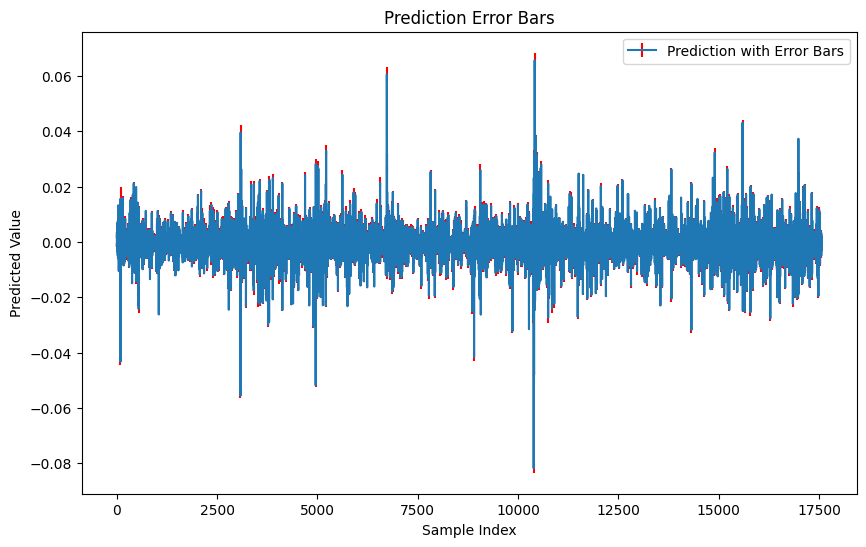

{'model': <Sequential name=sequential_75, built=True>,
 'hyperparams': {'learning_rate': 0.0003206044832303934,
  'batch_size': 24,
  'epochs': 42,
  'activation': 'relu',
  'lstm_units': 81,
  'lookback': 7}}

In [6]:
getOptimalModel(SAVE_MODEL)